# Library install

# 0. Import Library

In [13]:
import os
import imageio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


## 1. Load Data

In [14]:
# 경로 설정
data_dir = "./data/"
excel_file_path = data_dir+"oasis_cross-sectional-5708aa0a98d82080.xlsx"

In [15]:
# 엑셀 파일에서 인구통계학적 정보를 데이터프레임으로 로드 - 모든 정보를 가져옴
df = pd.read_excel(excel_file_path)
df = df[['ID', 'M/F', 'Hand', 'Age', 'Educ', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF', 'Delay']]

# CDR 값이 없는 경우, 결측값으로 간주하고 제거
df = df.dropna(subset=['CDR'])

In [16]:
# MRI, label, 인구통계 정보를 위한 리스트와 딕셔너리 생성
coronal_images = {}
sagittal_images = {}
transverse_images_gfc = {}
transverse_images_masked = {}
labels = []
demographics = {}

In [17]:
# 이미지 크기 조정 함수 정의 (이미지를 224x224로 변환)
def resize_image(image, new_shape=(224, 224)):
    current_shape = image.shape[:2]  # 2D 이미지이므로 앞의 두 차원만 사용
    zoom_factors = [n / c for n, c in zip(new_shape, current_shape)]
    return zoom(image, zoom_factors)

In [18]:
# 피험자 ID와 df 값을 매칭하여 딕셔너리에 저장하는 함수
def save_dictionary(subject_id):
    # 엑셀에서 해당 ID를 매칭하고 정보를 찾기
    subject_info = df[df['ID'] == subject_id]

    if not subject_info.empty:
        # CDR 값을 label로 사용
        cdr_value = subject_info['CDR'].values[0]
        labels.append(cdr_value)

        # 인구통계학적 정보 딕셔너리에 저장
        demographics[subject_id] = {
            'M/F': subject_info['M/F'].values[0],
            'Hand': subject_info['Hand'].values[0],
            'Age': subject_info['Age'].values[0],
            'Educ': subject_info['Educ'].values[0],
            'SES': subject_info['SES'].values[0],
            'MMSE': subject_info['MMSE'].values[0],
            'eTIV': subject_info['eTIV'].values[0],
            'nWBV': subject_info['nWBV'].values[0],
            'ASF': subject_info['ASF'].values[0],
            'Delay': subject_info['Delay'].values[0]
        }
    else:
        print(f"Label not found for subject: {subject_id}")  # label이 없는 피험자 출력

In [19]:
# 피험자 데이터 로드 및 저장
for disc_num in range(1, 13):  # 1~12 디스크 (OASIS 디스크 12개)
    disc_path = os.path.join(data_dir, f"oasis_cross-sectional_disc{disc_num}")

    # [디버깅] 디스크 경로가 존재하는지 확인
    if not os.path.exists(disc_path):
        print(f"Disc path does not exist: {disc_path}")
        continue

    for sub_folder in os.listdir(disc_path):  # disc 안의 폴더 탐색
        sub_folder_path = os.path.join(disc_path, sub_folder)

        if not os.path.isdir(sub_folder_path):  # [디버깅] 폴더가 아닌 경우 무시
            print(f"Skipping non-directory: {sub_folder_path}")
            continue

        for subject_dir in os.listdir(sub_folder_path):  # 피험자 폴더 탐색
            subject_path = os.path.join(sub_folder_path, subject_dir)

            if not os.path.isdir(subject_path): # [디버깅] 폴더가 아닌 경우 무시
                print(f"Skipping non-directory: {subject_path}")
                continue

            # MR1 경로 설정
            session_path = subject_path
            print(f"Processing session: {session_path}")

            if not os.path.exists(session_path): # [디버깅]
                print(f"Session path does not exist: {session_path}")
                continue

            # preprocessed 데이터 경로 (T88_111 폴더)
            t88_111_path = os.path.join(session_path, "PROCESSED", "MPRAGE", "T88_111")
            print(f"Checking T88_111 path: {t88_111_path}")

            if os.path.exists(t88_111_path):
                for file in os.listdir(t88_111_path):
                    file_path = os.path.join(t88_111_path, file)

                    # coronal 이미지 처리
                    if file.endswith("_cor_110.gif"):
                        print(f"Loading coronal .gif file: {file_path}")
                        try:
                            img = imageio.v2.imread(file_path)
                            img_resized = resize_image(img)
                            coronal_images[subject_dir] = img_resized
                        except Exception as e: # [디버깅]
                            print(f"Error loading coronal image: {e}")

                    # sagittal 이미지 처리
                    elif file.endswith("_sag_95.gif"):
                        print(f"Loading sagittal .gif file: {file_path}")
                        try:
                            img = imageio.v2.imread(file_path)
                            img_resized = resize_image(img)
                            sagittal_images[subject_dir] = img_resized
                        except Exception as e: # [디버깅]
                            print(f"Error loading sagittal image: {e}")

                    # transverse 이미지 처리
                    elif file.endswith("_tra_90.gif"):
                        if "masked_gfc" in file:
                            print(f"Loading masked transverse .gif file: {file_path}")
                            try:
                                img = imageio.v2.imread(file_path)
                                img_resized = resize_image(img)
                                transverse_images_masked[subject_dir] = img_resized
                            except Exception as e: # [디버깅]
                                print(f"Error loading masked transverse image: {e}")
                        else:
                            print(f"Loading regular transverse .gif file: {file_path}")
                            try:
                                img = imageio.v2.imread(file_path)
                                img_resized = resize_image(img)
                                transverse_images_gfc[subject_dir] = img_resized
                            except Exception as e: #[디버깅]
                                print(f"Error loading regular transverse image: {e}")

                    # 피험자 ID 그대로 추출
                    subject_id = subject_dir

                    # 피험자 ID와 엑셀 파일상 데이터 매칭하여 딕셔너리에 저장
                    save_dictionary(subject_id)
            else:
                print(f"T88_111 path does not exist: {t88_111_path}")

Skipping non-directory: ./data/oasis_cross-sectional_disc1/.DS_Store
Skipping non-directory: ./data/oasis_cross-sectional_disc1/disc1/.DS_Store
Processing session: ./data/oasis_cross-sectional_disc1/disc1/OAS1_0016_MR1
Checking T88_111 path: ./data/oasis_cross-sectional_disc1/disc1/OAS1_0016_MR1/PROCESSED/MPRAGE/T88_111
Loading masked transverse .gif file: ./data/oasis_cross-sectional_disc1/disc1/OAS1_0016_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0016_MR1_mpr_n3_anon_111_t88_masked_gfc_tra_90.gif
Loading coronal .gif file: ./data/oasis_cross-sectional_disc1/disc1/OAS1_0016_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0016_MR1_mpr_n3_anon_111_t88_gfc_cor_110.gif
Loading regular transverse .gif file: ./data/oasis_cross-sectional_disc1/disc1/OAS1_0016_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0016_MR1_mpr_n3_anon_111_t88_gfc_tra_90.gif
Loading sagittal .gif file: ./data/oasis_cross-sectional_disc1/disc1/OAS1_0016_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0016_MR1_mpr_n3_anon_111_t88_gfc_sag_95.gif
Processing session: ./da

## 2. Preprocessing

### 1) 결측치 처리

label와 mri가 동시에 존재하는 피실험자만 데이터셋으로 사용하기

In [20]:
valid_subjects = [subject for subject in demographics if subject in df['ID'].values]
coronal_images = {subject: coronal_images[subject] for subject in valid_subjects if subject in coronal_images}
sagittal_images = {subject: sagittal_images[subject] for subject in valid_subjects if subject in sagittal_images}
transverse_images_gfc = {subject: transverse_images_gfc[subject] for subject in valid_subjects if subject in transverse_images_gfc}
transverse_images_masked = {subject: transverse_images_masked[subject] for subject in valid_subjects if subject in transverse_images_masked}
labels = [df[df['ID'] == subject]['CDR'].values[0] for subject in valid_subjects]

In [21]:
# 최종 저장된 정보 출력
print(f"Coronal images: {len(coronal_images)}")
print(f"Sagittal images: {len(sagittal_images)}")
print(f"Regular transverse images: {len(transverse_images_gfc)}")
print(f"Masked transverse images: {len(transverse_images_masked)}")
print(f"총 label: {len(labels)}")
print(f"저장된 피험자 수: {len(demographics)}")

Coronal images: 212
Sagittal images: 212
Regular transverse images: 213
Masked transverse images: 213
총 label: 223
저장된 피험자 수: 223


### 2) Label encoding

In [22]:
def convert_images_to_array(image_dict):
    image_array = []
    for img in image_dict.values():
        # if 이미지가 흑백인 경우 : 채널을 추가하는 코드 - 모델에 입력 가능한 형태인 (height, width, 1)로 맞춤
        if len(img.shape) == 2:
            img = np.expand_dims(img, axis=-1)
        image_array.append(img)
    return np.array(image_array)

In [23]:
# 전체 치매군과 비치매군 인원수 출력
dementia_count = sum([1 if cdr >= 0.5 else 0 for cdr in labels])
non_dementia_count = len(labels) - dementia_count
print(f"Total Dementia: {dementia_count}, Total Non-dementia: {non_dementia_count}")

Total Dementia: 95, Total Non-dementia: 128


In [24]:
# 비치매군을 치매군의 개수에 맞게 랜덤 추출 (과적합 방지를 위해)
non_dementia_subjects = [subject for subject, cdr in zip(valid_subjects, labels) if cdr == 0]
np.random.seed(42)
non_dementia_subjects_balanced = np.random.choice(non_dementia_subjects, size=dementia_count, replace=False).tolist()

In [25]:
# 치매군과 밸런스맞춘 비치매군의 데이터셋을 합침
dementia_subjects = [subject for subject, cdr in zip(valid_subjects, labels) if cdr >= 0.5]
balanced_subjects = dementia_subjects + non_dementia_subjects_balanced

In [26]:
# label 1은 치매, label 0은 비치매로 설정
balanced_labels = [1] * len(dementia_subjects) + [0] * len(non_dementia_subjects_balanced)

## 3. Split dataset

In [27]:
# 데이터셋을 train/validation/test로 분할
train_subjects, temp_subjects, train_labels, temp_labels = train_test_split(
    balanced_subjects, balanced_labels, test_size=0.4, stratify=balanced_labels, random_state=42
)

val_subjects, test_subjects, val_labels, test_labels = train_test_split(
    temp_subjects, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

In [28]:
# 각 세트에 맞는 이미지들 준비 (coronal, sagittal, transverse, transverse_masked)
train_coronal = convert_images_to_array({subject: coronal_images[subject] for subject in train_subjects if subject in coronal_images})
val_coronal = convert_images_to_array({subject: coronal_images[subject] for subject in val_subjects if subject in coronal_images})
test_coronal = convert_images_to_array({subject: coronal_images[subject] for subject in test_subjects if subject in coronal_images})

train_sagittal = convert_images_to_array({subject: sagittal_images[subject] for subject in train_subjects if subject in sagittal_images})
val_sagittal = convert_images_to_array({subject: sagittal_images[subject] for subject in val_subjects if subject in sagittal_images})
test_sagittal = convert_images_to_array({subject: sagittal_images[subject] for subject in test_subjects if subject in sagittal_images})

train_transverse_gfc = convert_images_to_array({subject: transverse_images_gfc[subject] for subject in train_subjects if subject in transverse_images_gfc})
val_transverse_gfc = convert_images_to_array({subject: transverse_images_gfc[subject] for subject in val_subjects if subject in transverse_images_gfc})
test_transverse_gfc = convert_images_to_array({subject: transverse_images_gfc[subject] for subject in test_subjects if subject in transverse_images_gfc})

train_transverse_masked = convert_images_to_array({subject: transverse_images_masked[subject] for subject in train_subjects if subject in transverse_images_masked})
val_transverse_masked = convert_images_to_array({subject: transverse_images_masked[subject] for subject in val_subjects if subject in transverse_images_masked})
test_transverse_masked = convert_images_to_array({subject: transverse_images_masked[subject] for subject in test_subjects if subject in transverse_images_masked})


## 4. Normalization

In [29]:
# 정규화 함수 정의 (이미지의 픽셀 값을 0에서 1 사이로 정규화)
def normalize_image(image):
    # 이미지의 최대값이 0이 아니어야 정규화를 진행
    if image.max() > 0:
        return image / 255.0
    else:
        return image

In [30]:
# 정규화 적용 및 정규화 전후 값 출력 함수
def normalize_and_compare(image_array, image_type):
    print(f"Before Normalization: {image_type} Min={image_array.min()}, Max={image_array.max()}")
    normalized_images = normalize_image(image_array)
    print(f"After Normalization: {image_type} Min={normalized_images.min()}, Max={normalized_images.max()}")
    return normalized_images

In [31]:
# 이미지 배열에 정규화 적용
train_coronal = normalize_and_compare(train_coronal, 'Train Coronal')
val_coronal = normalize_and_compare(val_coronal, 'Validation Coronal')
test_coronal = normalize_and_compare(test_coronal, 'Test Coronal')

train_sagittal = normalize_and_compare(train_sagittal, 'Train Sagittal')
val_sagittal = normalize_and_compare(val_sagittal, 'Validation Sagittal')
test_sagittal = normalize_and_compare(test_sagittal, 'Test Sagittal')

train_transverse_gfc = normalize_and_compare(train_transverse_gfc, 'Train Transverse GFC')
val_transverse_gfc = normalize_and_compare(val_transverse_gfc, 'Validation Transverse GFC')
test_transverse_gfc = normalize_and_compare(test_transverse_gfc, 'Test Transverse GFC')

train_transverse_masked = normalize_and_compare(train_transverse_masked, 'Train Transverse Masked')
val_transverse_masked = normalize_and_compare(val_transverse_masked, 'Validation Transverse Masked')
test_transverse_masked = normalize_and_compare(test_transverse_masked, 'Test Transverse Masked')

Before Normalization: Train Coronal Min=0, Max=255
After Normalization: Train Coronal Min=0.0, Max=1.0
Before Normalization: Validation Coronal Min=0, Max=255
After Normalization: Validation Coronal Min=0.0, Max=1.0
Before Normalization: Test Coronal Min=0, Max=255
After Normalization: Test Coronal Min=0.0, Max=1.0
Before Normalization: Train Sagittal Min=0, Max=248
After Normalization: Train Sagittal Min=0.0, Max=0.9725490196078431
Before Normalization: Validation Sagittal Min=0, Max=239
After Normalization: Validation Sagittal Min=0.0, Max=0.9372549019607843
Before Normalization: Test Sagittal Min=0, Max=247
After Normalization: Test Sagittal Min=0.0, Max=0.9686274509803922
Before Normalization: Train Transverse GFC Min=0, Max=243
After Normalization: Train Transverse GFC Min=0.0, Max=0.9529411764705882
Before Normalization: Validation Transverse GFC Min=0, Max=231
After Normalization: Validation Transverse GFC Min=0.0, Max=0.9058823529411765
Before Normalization: Test Transverse GFC

In [32]:
# 최종 데이터셋 출력
print(f"Train set: {len(train_subjects)} subjects (Dementia: {sum(train_labels)}, Non-dementia: {len(train_labels) - sum(train_labels)})")
print(f"Validation set: {len(val_subjects)} subjects (Dementia: {sum(val_labels)}, Non-dementia: {len(val_labels) - sum(val_labels)})")
print(f"Test set: {len(test_subjects)} subjects (Dementia: {sum(test_labels)}, Non-dementia: {len(test_labels) - sum(test_labels)})")

Train set: 114 subjects (Dementia: 57, Non-dementia: 57)
Validation set: 38 subjects (Dementia: 19, Non-dementia: 19)
Test set: 38 subjects (Dementia: 19, Non-dementia: 19)


## 5. Modeling

In [33]:
train_images = train_coronal  # 학습할 이미지 데이터
train_labels = np.array(train_labels)  # 레이블 데이터

In [34]:
print(train_images.shape)
print(train_labels.shape)

(113, 224, 224, 1)
(114,)


In [86]:
# 데이터 증강 함수
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 데이터 증강 적용
datagen.fit(train_images)

In [87]:
def create_cnn_model(input_shape):
    model = models.Sequential()
    
    # 첫 번째 합성곱층
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    
    # 두 번째 합성곱층
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    
    # 세 번째 합성곱층
    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    
    # 평탄화
    model.add(layers.Flatten())
    
    # 완전 연결층
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))  # 이진 분류를 위한 출력층

    return model

In [88]:
model = create_cnn_model((224, 224, 1))  # 입력 이미지 크기에 맞게 조정
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [89]:
history = model.fit(train_images, train_labels, epochs=100, batch_size=32, validation_split=0.2)


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 743ms/step - accuracy: 0.4241 - loss: 17.6097 - val_accuracy: 0.4783 - val_loss: 4.7441
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 658ms/step - accuracy: 0.4704 - loss: 47.3990 - val_accuracy: 0.4783 - val_loss: 5.2239
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 702ms/step - accuracy: 0.4426 - loss: 20.1293 - val_accuracy: 0.4783 - val_loss: 5.8204
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 668ms/step - accuracy: 0.5444 - loss: 11.0091 - val_accuracy: 0.4783 - val_loss: 6.3669
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 662ms/step - accuracy: 0.6553 - loss: 7.4493 - val_accuracy: 0.4783 - val_loss: 6.8963
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 666ms/step - accuracy: 0.7010 - loss: 6.1605 - val_accuracy: 0.4783 - val_loss: 7.3588
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 683ms/step - accuracy: 0.6514 - loss: 5.8483 - val_accuracy: 0.4783 - val_loss: 7.8432
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 725ms/step - accuracy: 0.6370 - loss: 5.9025 - val_accuracy: 0.4783

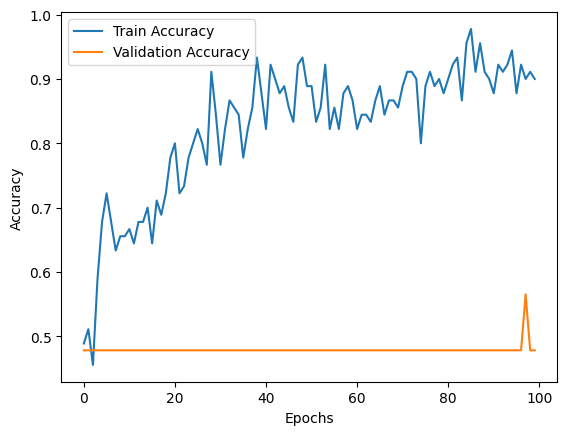

In [90]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()